# Importing Data
Value at Risk (Var-Covar) 


In [2]:
import pandas as pd
import numpy as np
import datetime as dt
from pandas_datareader import data as pdr
from scipy.stats import norm, t
import matplotlib.pyplot as plt
import yfinance as yf

# Function to fetch stock data and calculate returns, mean returns, and covariance matrix
def getData(stocks, start, end):
    # Download stock data from Yahoo Finance
    stockData = yf.download(stocks, start=start, end=end)['Close']
    # Calculate daily returns
    returns = stockData.pct_change()
    # Calculate mean returns
    meanReturns = returns.mean()
    # Calculate covariance matrix of returns
    covMatrix = returns.cov()
    return returns, meanReturns, covMatrix

# Portfolio Performance
def portfolioPerformance(weights, meanReturns, covMatrix, Time):
    # Calculate portfolio returns
    returns = np.sum(meanReturns * weights) * Time
    # Calculate portfolio standard deviation (risk)
    std = np.sqrt(np.dot(weights.T, np.dot(covMatrix, weights))) * np.sqrt(Time)
    return returns, std

# List of top Indian stock tickers
stockList = ['RELIANCE', 'TCS', 'HDFCBANK', 'INFY', 'HINDUNILVR', 'ICICIBANK']
# Append '.NS' to each ticker to specify Indian stocks
stocks = [stock + '.NS' for stock in stockList]

# Define the end date as today
endDate = dt.datetime.now()
# Define the start date as 800 days before the end date
startDate = endDate - dt.timedelta(days=800)

# Print the dates and stock tickers
print(f"Fetching data from {startDate.date()} to {endDate.date()}")
print(f"Stocks: {', '.join(stocks)}")

# Fetch stock data and calculate returns, mean returns, and covariance matrix
returns, meanReturns, covMatrix = getData(stocks, start=startDate, end=endDate)
# Drop any rows with NaN values in returns
returns = returns.dropna()

# Generate random weights for the stocks
weights = np.random.random(len(returns.columns))
# Normalize the weights so that their sum is 1
weights /= np.sum(weights)

# Calculate the portfolio returns
returns['portfolio'] = returns.dot(weights)

# Print the first few rows of the returns DataFrame to verify
print(returns.to_string())

Fetching data from 2022-08-27 to 2024-11-04
Stocks: RELIANCE.NS, TCS.NS, HDFCBANK.NS, INFY.NS, HINDUNILVR.NS, ICICIBANK.NS


[*********************100%***********************]  6 of 6 completed


Ticker                     HDFCBANK.NS  HINDUNILVR.NS  ICICIBANK.NS   INFY.NS  RELIANCE.NS    TCS.NS  portfolio
Date                                                                                                           
2022-08-30 00:00:00+00:00     0.032444       0.032631      0.036747  0.021344     0.015514  0.025091   0.027728
2022-09-01 00:00:00+00:00    -0.009387      -0.020246     -0.014595 -0.019257    -0.029398 -0.024742  -0.018383
2022-09-02 00:00:00+00:00     0.009068      -0.000921     -0.002230 -0.007649    -0.011678 -0.000415  -0.001817
2022-09-05 00:00:00+00:00     0.006429      -0.001152      0.011520  0.005712     0.015531  0.000958   0.008649
2022-09-06 00:00:00+00:00    -0.003813      -0.010574      0.001360 -0.004243     0.010526 -0.002027   0.000297
2022-09-07 00:00:00+00:00    -0.004734      -0.003303     -0.008431  0.001752    -0.005815  0.007211  -0.004052
2022-09-08 00:00:00+00:00     0.010322       0.004893      0.025793  0.012520     0.001414  0.006366   0

In [3]:
def historicalVaR(returns, alpha=5):
    """
    Read in a pandas dataframe of returns / a pandas series of returns
    Output the percentile of the distribution at the given alpha confidence level
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)

    # A passed user-defined-function will be passed a Series for evaluation.
    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historicalVaR, alpha=alpha)

    else:
        raise TypeError("Expected returns to be dataframe or series")

def historicalCVaR(returns, alpha=5):
    """
    Read in a pandas dataframe of returns / a pandas series of returns
    Output the CVaR for dataframe / series
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= historicalVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()

    # A passed user-defined-function will be passed a Series for evaluation.
    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historicalCVaR, alpha=alpha)

    else:
        raise TypeError("Expected returns to be dataframe or series")

# 100 days
Time = 100

hVaR = -historicalVaR(returns['portfolio'], alpha=5)*np.sqrt(Time)
hCVaR = -historicalCVaR(returns['portfolio'], alpha=5)*np.sqrt(Time)
pRet, pStd = portfolioPerformance(weights, meanReturns, covMatrix, Time)

InitialInvestment = 10000
print('Expected Portfolio Return:      ', round(InitialInvestment*pRet,2))
print('Value at Risk 95th CI    :      ', round(InitialInvestment*hVaR,2))
print('Conditional VaR 95th CI  :      ', round(InitialInvestment*hCVaR,2))


Expected Portfolio Return:       471.55
Value at Risk 95th CI    :       1282.46
Conditional VaR 95th CI  :       1856.17


In [4]:
def var_parametric(portofolioReturns, portfolioStd, distribution='normal', alpha=5, dof=6):
    # because the distribution is symmetric
    if distribution == 'normal':
        VaR = norm.ppf(1-alpha/100)*portfolioStd - portofolioReturns
    elif distribution == 't-distribution':
        nu = dof
        VaR = np.sqrt((nu-2)/nu) * t.ppf(1-alpha/100, nu) * portfolioStd - portofolioReturns
    else:
        raise TypeError("Expected distribution type 'normal'/'t-distribution'")
    return VaR

def cvar_parametric(portofolioReturns, portfolioStd, distribution='normal', alpha=5, dof=6):
    if distribution == 'normal':
        CVaR = (alpha/100)**-1 * norm.pdf(norm.ppf(alpha/100))*portfolioStd - portofolioReturns
    elif distribution == 't-distribution':
        nu = dof
        xanu = t.ppf(alpha/100, nu)
        CVaR = -1/(alpha/100) * (1-nu)**(-1) * (nu-2+xanu**2) * t.pdf(xanu, nu) * portfolioStd - portofolioReturns
    else:
        raise TypeError("Expected distribution type 'normal'/'t-distribution'")
    return CVaR

normVaR = var_parametric(pRet, pStd)
normCVaR = cvar_parametric(pRet, pStd)

tVaR = var_parametric(pRet, pStd, distribution='t-distribution')
tCVaR = cvar_parametric(pRet, pStd, distribution='t-distribution')

print("Normal VaR 95th CI       :      ", round(InitialInvestment*normVaR,2))
print("Normal CVaR 95th CI      :      ", round(InitialInvestment*normCVaR,2))
print("t-dist VaR 95th CI       :      ", round(InitialInvestment*tVaR,2))
print("t-dist CVaR 95th CI      :      ", round(InitialInvestment*tCVaR,2))

Normal VaR 95th CI       :       889.3
Normal CVaR 95th CI      :       1235.01
t-dist VaR 95th CI       :       841.1
t-dist CVaR 95th CI      :       1312.32


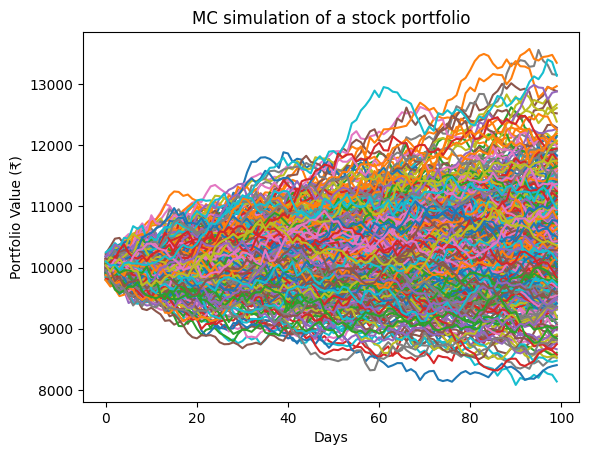

In [5]:
# Monte Carlo Method
mc_sims = 400 # number of simulations
T = 100 #timeframe in days

meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns)
meanM = meanM.T

portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)

initialPortfolio = 10000

for m in range(0, mc_sims):
    # MC loops
    Z = np.random.normal(size=(T, len(weights)))
    L = np.linalg.cholesky(covMatrix)
    dailyReturns = meanM + np.inner(L, Z)
    portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initialPortfolio
     

plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value (₹)')
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')
plt.show()

In [8]:
def mcVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: percentile on return distribution to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected a pandas data series.")

def mcCVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: CVaR or Expected Shortfall to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= mcVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()
    else:
        raise TypeError("Expected a pandas data series.")
    
portResults = pd.Series(portfolio_sims[-1,:])

VaR = initialPortfolio - mcVaR(portResults, alpha=5)
CVaR = initialPortfolio - mcCVaR(portResults, alpha=5)

print('VaR ₹ {}'.format(round(VaR,2)))
print('CVaR ₹ {}'.format(round(CVaR,2)))

VaR ₹ 1026.73
CVaR ₹ 1318.4


In [7]:
print("\nVaR:")

print(' historical VaR 95th CI   :      ', round(InitialInvestment*hVaR,2))
print(" Normal VaR 95th CI       :      ", round(InitialInvestment*normVaR,2))
print(" t-dist VaR 95th CI       :      ", round(InitialInvestment*tVaR,2))
print(" MC VaR  95th CI          :      ", round(VaR,2))


print("\nCVaR:")

print(' historical CVaR 95th CI  :      ', round(InitialInvestment*hCVaR,2))
print(" Normal CVaR 95th CI      :      ", round(InitialInvestment*normCVaR,2))
print(" t-dist CVaR 95th CI      :      ", round(InitialInvestment*tCVaR,2))
print(" MC CVaR 95th CI          :      ", round(CVaR,2))


VaR:
 historical VaR 95th CI   :       1282.46
 Normal VaR 95th CI       :       889.3
 t-dist VaR 95th CI       :       841.1
 MC VaR  95th CI          :       1026.73

CVaR:
 historical CVaR 95th CI  :       1856.17
 Normal CVaR 95th CI      :       1235.01
 t-dist CVaR 95th CI      :       1312.32
 MC CVaR 95th CI          :       1318.4
